# **第8章: ニューラルネット**

*深層学習フレームワークの使い方を学び，ニューラルネットワークに基づくカテゴリ分類を実装します．*

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

##70 単語ベクトルの和による特徴量

In [1]:
!pwd
!wc -l ./data/NewsAggregatorDataset/newsCorpora.csv
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./data/NewsAggregatorDataset/newsCorpora.csv > ./work/newsCorpora_re.csv

/home/kai/100knock-crash-2023/trainee_kai/chapter08
422937 ./data/NewsAggregatorDataset/newsCorpora.csv


In [2]:
#pandasのDataFrameに格納
import pandas as pd
df = pd.read_table('./work/newsCorpora_re.csv', header=None, sep='\t', names=['TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']) #dataframe型に格納する
df = df[(df['PUBLISHER'] == 'Reuters') | (df['PUBLISHER'] == 'Huffington Post') | (df['PUBLISHER'] == 'Businessweek') | (df['PUBLISHER'] == 'Contactmusic.com') | (df['PUBLISHER'] == 'Daily Mail')] #特定のpublisherの記事を抽出
df = df.sample(frac=1,random_state=0) #sampleはランダムにサンプリングするメソッド　fracで指定した割合を母集団から取ってくる、１にするとすべて取ってくる、つまりすべてランダムに並べ替える

#train_test_splitを使って分割
from sklearn.model_selection import train_test_split
df = df.reset_index()
train, valid_test = train_test_split(df,test_size = 0.2)
valid, test = train_test_split(valid_test,test_size = 0.5)

#データの保存
train.to_csv('train.txt',sep='\t',index=False,header=False)#locとつけないとエラーになる、完全には理解できてない
valid.to_csv('valid.txt',sep='\t',index=False,header=False)#複数要素(title,category)で抽出するときにはリストにして渡す
test.to_csv('test.txt',sep='\t',index=False,header=False)#カテゴリ名と記事見出しのタブ区切り形式なのでsep=\t

In [1]:
from pymagnitude import Magnitude
vectors = Magnitude("/home/kai/100knock-crash-2023/trainee_kai/chapter07/work/GoogleNews-vectors-negative300.magnitude")

In [ ]:
import string
import torch
import numpy as np
import nltk
nltk.download('punkt')
# from tqdm.notebook import tqdm 
import string
import torch

def remove_symbols(text):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    words = text.translate(table)
    return words


def transform_w2v(df):
    all_text_vec = np.zeros(((0,300)))
    #lines:単語ごとに区切ってリスト化されたタイトルたちのリスト
    #nltkでトークンにできるもののみリストにする
    lines = df.apply(lambda x:remove_symbols(x)).apply(lambda x: [str(token) for token in nltk.word_tokenize(x)]).to_list()
    for line in lines:
        try:
            #magnitudeに登録されている単語のみベクトルにする（計算時間短縮のため）
            text_vec = np.mean(vectors.query([word for word in line if word in vectors]))
            all_text_vec = np.vstack((all_text_vec, text_vec))
        except ValueError:
            #magnitudeに登録されていない単語は０に
            all_text_vec = np.vstack((all_text_vec, np.zeros((1,300))))
    return all_text_vec

# 特徴ベクトルの作成
X_test = transform_w2v(test['TITLE'])
print('checkpoint1')
X_train = transform_w2v(train['TITLE'])
print('checkpoint2')
X_valid = transform_w2v(valid['TITLE'])

In [21]:
print(X_train)
print(X_valid.shape)
print(X_test.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1336, 300)
(1336, 300)


In [ ]:
X_train = torch.stack([x for x in X_train])
X_valid = torch.stack([x for x in X_valid])
X_test = torch.stack([x for x in X_test])

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)



In [8]:
category_dict = {'b':0,'t':1,'e':2,'m':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x:category_dict[x]).values,dtype=torch.float32)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x:category_dict[x]).values,dtype=torch.float32)
y_test = torch.tensor(test['CATEGORY'].map(lambda x:category_dict[x]).values,dtype=torch.float32)

print(y_train.size())
print(y_train)

torch.Size([10684])
tensor([0., 2., 2.,  ..., 0., 2., 0.])


In [9]:
torch.save(X_train, './work/X_train.pt')
torch.save(X_valid, './work/X_valid.pt')
torch.save(X_test, './work/X_test.pt')
torch.save(y_train, './work/y_train.pt')
torch.save(y_valid, './work/y_valid.pt')
torch.save(y_test, './work/y_test.pt')

In [2]:
import torch

X_train = torch.load('./work/X_train.pt')
X_valid = torch.load('./work/X_valid.pt')
X_test = torch.load('./work/X_test.pt')
y_train = torch.load('./work/y_train.pt')
y_valid = torch.load('./work/y_valid.pt')
y_test = torch.load('./work/y_test.pt')

## 71 単層ニューラルネットワークによる予測

In [ ]:
##自分でソフトマックス関数を定義してやってみたセル、エラーが出て途中でやめた
# import numpy as np

# def softmax(x):
#     u = np.sum(np.exp(x))
#     return np.exp(x)/u

# W = torch.randn(300,4)
# softmax_of_x_1 = softmax(torch.matmul(X_train[0].float(),W))

# print(softmax_of_x_1)
# print(softmax_of_x_1to4)


In [3]:
# softmaxの計算(1次元)
import torch
import torch.nn as nn

device = torch.device("cpu")
# X = tourch.tensor(train_X, requires_grad=False, dtype=torch.float.32)
torch.manual_seed(42)
X = X_train.float()
print(X[0].shape)

W = torch.randn((300,4), requires_grad=True)
print(W.shape)

softmax = torch.nn.Softmax(dim=0) #1次元の計算はdim=0
y1 = softmax(torch.matmul(X[0], W))
print(y1.data)

torch.Size([300])
torch.Size([300, 4])
tensor([0.2646, 0.2222, 0.2896, 0.2236])


In [7]:
# softmaxの計算(2次元)
import torch
import torch.nn as nn

device = torch.device("cpu")
torch.manual_seed(42)

X = X_train.float()
print(X[:4].shape)

W = torch.randn((300,4), requires_grad=True)
W = torch.randn((300,4), requires_grad=True)
print(W.shape)

softmax = torch.nn.Softmax(dim=1) #1次元の計算はdim=0
y1 = softmax(torch.matmul(X[:4], W))
print(y1.data)

torch.Size([4, 300])
torch.Size([300, 4])
tensor([[0.2957, 0.4458, 0.1171, 0.1414],
        [0.2712, 0.4329, 0.1243, 0.1716],
        [0.2221, 0.3158, 0.1424, 0.3197],
        [0.3492, 0.2546, 0.1694, 0.2268]])


## 72 損失と勾配の計算

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
from IPython.display import display

In [5]:
Y = y_train.to(torch.int64)
print(Y.shape)
#W.grad.zero_()
#交差エントロピーを定義
criterion = nn.CrossEntropyLoss()
#損失を計算
loss = criterion(torch.matmul(X[0],W), Y[0])
#勾配を計算
loss.backward()
print(f'損失：{loss}')
print(f'勾配：{W.grad}')
print(W.grad.shape)

torch.Size([10684])
損失：1.3294508457183838
勾配：tensor([[-0.0121,  0.0037,  0.0048,  0.0037],
        [-0.0196,  0.0059,  0.0077,  0.0060],
        [ 0.0168, -0.0051, -0.0066, -0.0051],
        ...,
        [-0.0109,  0.0033,  0.0043,  0.0033],
        [-0.0116,  0.0035,  0.0046,  0.0035],
        [ 0.0076, -0.0023, -0.0030, -0.0023]])
torch.Size([300, 4])


In [29]:
print(Y.shape)
W.grad.zero_()
#交差エントロピーを定義
criterion = nn.CrossEntropyLoss()
#４つの入力それぞれの損失を計算し、その平均を取る
loss = torch.mean(torch.stack([criterion(torch.matmul(x,W) , Y[0]) for x in X[0:4]]),dim=0)
#勾配を計算
loss.backward()
print(f'損失：{loss}')
print(f'勾配：{W.grad}')
print(W.grad.shape)


torch.Size([10684])
損失：1.2699525356292725
勾配：tensor([[-8.3264e-03,  3.4288e-03,  1.8856e-03,  3.0120e-03],
        [-2.0181e-02,  9.8972e-03,  4.1590e-03,  6.1247e-03],
        [ 4.7759e-03, -3.0061e-03, -1.1858e-03, -5.8389e-04],
        ...,
        [ 1.2283e-03, -3.7210e-05, -7.7288e-05, -1.1138e-03],
        [-8.9073e-03,  5.5489e-03,  1.5084e-03,  1.8501e-03],
        [ 6.7556e-03, -3.7951e-03, -1.1882e-03, -1.7723e-03]])
torch.Size([300, 4])


## 73 確率的勾配降下法による学習

In [6]:
# pytorchの再現性のためのシードを一斉指定する関数
def torch_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [11]:
# モデルの定義、そのまま持ってきている クラスの理解完璧じゃない
class Net(nn.Module):
    #コンストラクタという特殊関数、インスタンスを初期化する
    def __init__(self, n_input, n_output):
        # 親クラスnn.Moduleの初期化呼び出し
        super().__init__()
    
        # 出力層の定義、Net.fc1(function1)として線形ニューラルネットを定義
        self.fc1 = nn.Linear(n_input, n_output, bias=False)  # 題意を汲み取ると、今回はバイアスを考えない設定にすべき
    
    # 予測関数の定義
    def forward(self, x):
        x1 = self.fc1(x)
        return x1
model = Net(300,4)

In [15]:
#デバイスを指定
device = torch.device("cpu")
#乱数シード値初期化
torch.seed()
#モデルを設定
model = Net(300,4)
#モデルの概要表示
print(model)

# model.zero_grad()

# モデルの概要表示、実行に1分以上かかってやめた
# from torchinfo import summary
# summary(model,X_train.shape)

Net(
  (fc1): Linear(in_features=300, out_features=4, bias=False)
)


In [12]:
print(X_train.dtype)
print(y_train.dtype)
model.zero_grad()

torch.float64
torch.float32


In [8]:
#学習率
lr = 0.1
#エポック数
num_epochs = 100
history_75 = np.zeros((0,3))
#損失関数
criterion = nn.CrossEntropyLoss()
#最適化関数 SGD: stochastic gradient descent 確率的勾配降下法
optimizer = optim.SGD(model.parameters(), lr=lr)

base_epochs = len(history_75)
#デバイスを切り替えてる、なくても動きはする？
model = model.to(device)

#ここから学習の本体
for epoch in range(base_epochs, base_epochs+num_epochs):
    train_loss, train_acc = 0,0
    val_loss, val_acc = 0,0
    #型を揃えないとエラー
    inputs = X_train.to(torch.float32)
    labels = y_train.to(torch.int64)
    #デバイスの割り当て
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    '''訓練フェーズ'''
    model.train()
    #勾配の初期化
    optimizer.zero_grad()
    #予測計算
    outputs = model(inputs)
    #損失計算
    loss = criterion(outputs, labels)
    #勾配計算
    loss.backward()
    #パラメータ修正
    optimizer.step()
    
    #予測値算出
    predicted = torch.max(outputs, 1)[1]
    #損失と精度の計算
    train_loss = loss.item()
    #正解した数を数えて、長さで割る
    train_acc = (predicted == labels).sum().item() / len(labels)
    
    #10回ごとに表示
    if ((epoch+1)%10 == 0):
        print (f'Epoch 【{epoch+1}/{num_epochs+base_epochs}】,train_loss: {train_loss}, train_acc:{train_acc}')
    item = np.array([epoch+1, train_loss, train_acc])
    history_75 = np.vstack((history_75, item))
    

Epoch 【10/100】,train_loss: 1.3752176761627197, train_acc:0.4121115687008611
Epoch 【20/100】,train_loss: 1.3679872751235962, train_acc:0.4191314114563834
Epoch 【30/100】,train_loss: 1.3610306978225708, train_acc:0.420067390490453
Epoch 【40/100】,train_loss: 1.3543370962142944, train_acc:0.41941220516660427
Epoch 【50/100】,train_loss: 1.3478963375091553, train_acc:0.42016098839385996
Epoch 【60/100】,train_loss: 1.3416982889175415, train_acc:0.4198801946836391
Epoch 【70/100】,train_loss: 1.3357335329055786, train_acc:0.4193186072631973
Epoch 【80/100】,train_loss: 1.3299925327301025, train_acc:0.4181954324223137
Epoch 【90/100】,train_loss: 1.3244667053222656, train_acc:0.41894421564956946
Epoch 【100/100】,train_loss: 1.3191471099853516, train_acc:0.41847622613253466


## 74 正解率の計測

In [9]:
#学習データでの予測
inputs = X_train.to(torch.float32)
labels = y_train.to(torch.int64)
#予測計算
outputs = model(inputs)
#予測値算出
predicted = torch.max(outputs, 1)[1]
train_acc = (predicted == labels).sum().item() / len(labels)
print(f'train_acc:{train_acc}')

train_acc:0.41810183451890676


In [10]:
#評価データでの予測
inputs = X_valid.to(torch.float32)
labels = y_valid.to(torch.int64)
#予測計算
outputs = model(inputs)
#予測値算出
predicted = torch.max(outputs, 1)[1]
valid_acc = (predicted == labels).sum().item() / len(labels)
print(f'valid_acc:{valid_acc}')

valid_acc:0.4251497005988024


## 75 損失と正解率のプロット

In [1]:
# !wandb loginをターミナルで実行

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [21]:
# W&B の初期設定
import wandb
# 保存したいハイパーパラメータを指定
config_dict = {
        "input_dim": X_train.shape[1],
        "output_dim": len(np.unique(y_train)),
        "lr": 0.1,
        "epoch": 100,
        "optimizer": "SGD",
        "loss": "CrossEntropyLoss",
        "metric": "accuracy",
    }
# W&B の実行を初期化
wandb.init(
    project="nlp100knock-ch08",
    name='q75',
    config=config_dict
    )
# 保存したハイパーパラメータを取得(dict形式)
config = wandb.config

In [22]:
#重みを学習前に戻すには？

#訓練データ、検証データそれぞれでの損失、正解率を計算
import matplotlib.pyplot as plt
import japanize_matplotlib
import wandb

# wandb初期化時に保存したハイパーパラメータを取得(dict形式)
config = wandb.config



lr = 0.1
num_epochs = 100
history_75 = np.zeros((0,5))
#損失関数
criterion = nn.CrossEntropyLoss()
#最適化関数 SGD: stochastic gradient descent 確率的勾配降下法
optimizer = optim.SGD(model.parameters(), lr=lr)

# log_freqで指定したepochおきに、netモデル内のパラメータ(checkpoint)と勾配を記録 (optional)
wandb.watch(model, criterion, log="all", log_freq=100)

base_epochs = len(history_75)
#デバイスを切り替えてる
model = model.to(device)
unit4plot = len(history_75)/10

for epoch in range(base_epochs, base_epochs+num_epochs):
    train_loss, train_acc = 0,0
    val_loss, val_acc = 0,0
    #デバイスの割り当て
    inputs = X_train.to(torch.float32)
    labels = y_train.to(torch.int64)
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    val_inputs = X_valid.to(torch.float32)
    val_labels = y_valid.to(torch.int64)
    val_inputs = inputs.to(device)
    val_labels = labels.to(device)
    
    '''訓練フェーズ'''
    model.train()
    #勾配の初期化
    optimizer.zero_grad()
    #予測計算
    outputs = model(inputs)
    #学習データの損失計算
    loss = criterion(outputs, labels)
    #学習データの勾配計算
    loss.backward()
    #パラメータ修正
    optimizer.step()
    
    #予測値算出
    predicted = torch.max(outputs, 1)[1]
    #損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum().item() / len(labels)
    
    model.eval()
    with torch.no_grad():
        #検証データの予測計算
        val_outputs = model(val_inputs)
        #検証データの損失計算
        loss = criterion(val_outputs,val_labels)
        #予測値算出
        val_predicted = torch.max(val_outputs, 1)[1]
        #損失と精度の計算
        val_loss = loss.item()
        val_acc = (val_predicted == val_labels).sum().item() / len(val_labels)
    
    if ((epoch+1)%10 == 0):
        print (f'Epoch 【{epoch+1}/{num_epochs+base_epochs}】,train_loss: {train_loss}, train_acc:{train_acc}, val_loss: {val_loss}, val_acc:{val_acc}')
        wandb.log({"train_loss":train_loss,"train_acc":train_acc,"val_loss":val_loss,"val_acc":val_acc})
    item = np.array([epoch+1, train_loss, train_acc, val_loss, val_acc])
    history_75 = np.vstack((history_75, item))

wandb.finish()
print(history_75)

Epoch 【10/100】,train_loss: 1.2436702251434326, train_acc:0.41791463871209283, val_loss: 1.2434264421463013, val_acc:0.41791463871209283
Epoch 【20/100】,train_loss: 1.2412689924240112, train_acc:0.4180082366154998, val_loss: 1.2410334348678589, val_acc:0.4180082366154998
Epoch 【30/100】,train_loss: 1.2389500141143799, train_acc:0.4186634219393486, val_loss: 1.238722562789917, val_acc:0.41838262822912764
Epoch 【40/100】,train_loss: 1.2367100715637207, train_acc:0.4185698240359416, val_loss: 1.2364904880523682, val_acc:0.4185698240359416
Epoch 【50/100】,train_loss: 1.234546422958374, train_acc:0.41847622613253466, val_loss: 1.2343339920043945, val_acc:0.41838262822912764
Epoch 【60/100】,train_loss: 1.2324556112289429, train_acc:0.4191314114563834, val_loss: 1.232250452041626, val_acc:0.41950580307001123
Epoch 【70/100】,train_loss: 1.2304352521896362, train_acc:0.42053538000748786, val_loss: 1.2302370071411133, val_acc:0.4207225758143018
Epoch 【80/100】,train_loss: 1.228482723236084, train_acc:0.

train_acc,▁▁▃▃▂▄██▆▅
train_loss,█▇▆▅▅▄▃▂▂▁
val_acc,▁▁▂▃▂▅██▆▅
val_loss,█▇▆▅▅▄▃▂▂▁
train_acc,0.4196
train_loss,1.22477
val_acc,0.41951
val_loss,1.22459


[[  1.           1.24590456   0.41688506   1.24565268   0.41707226]
 [  2.           1.24565268   0.41707226   1.24540174   0.41716586]
 [  3.           1.24540174   0.41716586   1.24515188   0.41725945]
 [  4.           1.24515188   0.41725945   1.24490273   0.41735305]
 [  5.           1.24490273   0.41735305   1.24465454   0.41716586]
 [  6.           1.24465454   0.41716586   1.24440718   0.41744665]
 [  7.           1.24440718   0.41744665   1.24416065   0.41735305]
 [  8.           1.24416065   0.41735305   1.24391508   0.41763385]
 [  9.           1.24391508   0.41763385   1.24367023   0.41791464]
 [ 10.           1.24367023   0.41791464   1.24342644   0.41791464]
 [ 11.           1.24342644   0.41791464   1.24318337   0.41791464]
 [ 12.           1.24318337   0.41791464   1.24294114   0.41819543]
 [ 13.           1.24294114   0.41819543   1.24269962   0.41810183]
 [ 14.           1.24269962   0.41810183   1.24245918   0.41810183]
 [ 15.           1.24245918   0.41810183   1.242

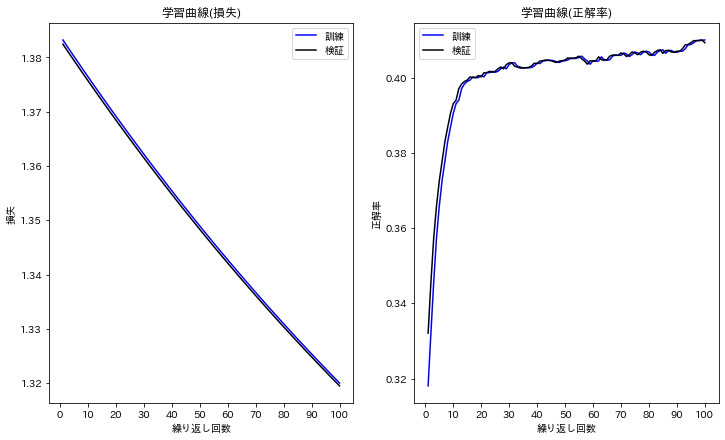

## 76 チェックポイント

In [13]:
# W&B の初期設定
import wandb
# 保存したいハイパーパラメータを指定
config_dict = {
        "input_dim": X_train.shape[1],
        "output_dim": len(np.unique(y_train)),
        "lr": 0.1,
        "epoch": 100,
        "optimizer": "SGD",
        "loss": "CrossEntropyLoss",
        "metric": "accuracy",
    }
# W&B の実行を初期化
wandb.init(
    project="nlp100knock-ch08",
    name='q75',
    config=config_dict
    )
# 保存したハイパーパラメータを取得(dict形式)
config = wandb.config

In [25]:
#訓練データ、検証データそれぞれでの損失、正解率を計算
import matplotlib.pyplot as plt
import japanize_matplotlib

model = Net(300,4)
lr = 0.1
num_epochs = 100
history_76 = np.zeros((0,5))
#損失関数
criterion = nn.CrossEntropyLoss()
#最適化関数 SGD: stochastic gradient descent 確率的勾配降下法
optimizer = optim.SGD(model.parameters(), lr=lr)

base_epochs = len(history_76)
#デバイスを切り替えてる
model = model.to(device)
unit4plot = len(history_76)/10


for epoch in range(base_epochs, base_epochs+num_epochs):
    train_loss, train_acc = 0,0
    val_loss, val_acc = 0,0
    #デバイスの割り当て
    inputs = X_train.to(torch.float32)
    labels = y_train.to(torch.int64)
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    val_inputs = X_valid.to(torch.float32)
    val_labels = y_valid.to(torch.int64)
    val_inputs = inputs.to(device)
    val_labels = labels.to(device)
    
    '''訓練フェーズ'''
    model.train()
    #勾配の初期化
    optimizer.zero_grad()
    #予測計算
    outputs = model(inputs)
    #学習データの損失計算
    loss = criterion(outputs, labels)
    #学習データの勾配計算
    loss.backward()
    #パラメータ修正
    optimizer.step()
    
    #予測値算出
    predicted = torch.max(outputs, 1)[1]
    #損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum().item() / len(labels)
    
    model.eval()
    with torch.no_grad():
        #検証データの予測計算
        val_outputs = model(val_inputs)
        #検証データの損失計算
        loss = criterion(val_outputs,val_labels)
        #予測値算出
        val_predicted = torch.max(val_outputs, 1)[1]
        #損失と精度の計算
        val_loss = loss.item()
        val_acc = (val_predicted == val_labels).sum().item() / len(val_labels)
    
    if ((epoch+1)%10 == 0):
        print (f'Epoch 【{epoch+1}/{num_epochs+base_epochs}】,train_loss: {train_loss}, train_acc:{train_acc}, val_loss: {val_loss}, val_acc:{val_acc}')
        torch.save(model.state_dict(), "work/checkpoints/q76.pth")
        
    item = np.array([epoch+1, train_loss, train_acc, val_loss, val_acc])
    history_76 = np.vstack((history_76, item))


Epoch 【10/100】,train_loss: 1.3779172897338867, train_acc:0.40116061400224634, val_loss: 1.3771709203720093, val_acc:0.40228378884312993
Epoch 【20/100】,train_loss: 1.3705813884735107, train_acc:0.4067764882066642, val_loss: 1.3698633909225464, val_acc:0.40705728191688506
Epoch 【30/100】,train_loss: 1.3635233640670776, train_acc:0.4087420441782104, val_loss: 1.3628323078155518, val_acc:0.4087420441782104
Epoch 【40/100】,train_loss: 1.3567320108413696, train_acc:0.4092100336952452, val_loss: 1.3560670614242554, val_acc:0.40911643579183826
Epoch 【50/100】,train_loss: 1.3501969575881958, train_acc:0.4093036315986522, val_loss: 1.3495571613311768, val_acc:0.4088356420816174
Epoch 【60/100】,train_loss: 1.3439080715179443, train_acc:0.4101460127293149, val_loss: 1.343292474746704, val_acc:0.409771621115687
Epoch 【70/100】,train_loss: 1.3378559350967407, train_acc:0.40958442530887307, val_loss: 1.3372633457183838, val_acc:0.4101460127293149
Epoch 【80/100】,train_loss: 1.3320311307907104, train_acc:0.

## 77 ミニバッチ化

In [ ]:
#TensorDatasetの練習
dataset = torch.utils.data.TensorDataset(X_train.to(torch.float32).to(device),y_train.to(torch.int64).to(device))
train_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=True)
print(y_train.shape)
# for x,y in train_loader:
#     print(x.shape)
#     print(y.shape[0])

In [8]:
# W&B の初期設定
import wandb
# 保存したいハイパーパラメータを指定
config_dict = {
        "input_dim": X_train.shape[1],
        "output_dim": len(np.unique(y_train)),
        "lr": 0.1,
        "epoch": 100,
        "optimizer": "SGD",
        "loss": "CrossEntropyLoss",
        "metric": "accuracy",
    }
# W&B の実行を初期化
wandb.init(
    project="nlp100knock-ch08",
    name='q77',
    config=config_dict
    )
# 保存したハイパーパラメータを取得(dict形式)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kai-satou-r8 (kaikaikaikai). Use `wandb login --relogin` to force relogin


In [19]:
#訓練データ、検証データそれぞれでの損失、正解率を計算
import matplotlib.pyplot as plt
import japanize_matplotlib


torch.device('cpu')

lr = 0.1#下げてみたらいいかも
num_epochs = 100
history_77 = np.zeros((0,5))
#損失関数
criterion = nn.CrossEntropyLoss()
#最適化関数 SGD: stochastic gradient descent 確率的勾配降下法
optimizer = optim.SGD(model.parameters(), lr=lr)
base_epochs = len(history_77)
#デバイスを切り替えてる
model = model.to(device)

#wandbに関するところ
config = wandb.config
base_epochs = len(history_77)
model = model.to(device)
wandb.watch(model, criterion, log="all", log_freq=10)

import torch.utils.data
batch_size = 32

dataset = torch.utils.data.TensorDataset(X_train.to(torch.float32).to(device),y_train.to(torch.int64).to(device))
train_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=True)

dataset = torch.utils.data.TensorDataset(X_valid.to(torch.float32).to(device),y_valid.to(torch.int64).to(device))
valid_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=False)


for epoch in range(base_epochs, base_epochs+num_epochs):
    train_loss, train_acc = 0,0
    val_loss, val_acc = 0,0
    #デバイスの割り当て
    model.train()
    count = 0
    '''訓練フェーズ'''
    for inputs, labels in train_loader:
        count += labels.shape[0]
        #勾配の初期化
        optimizer.zero_grad()
        #予測計算
        outputs = model(inputs)
        #学習データの損失計算
        loss = criterion(outputs, labels)
        #学習データの勾配計算
        loss.backward()
        #パラメータ修正
        optimizer.step()
        
        #予測値算出
        predicted = torch.max(outputs, 1)[1]
        #損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item()
        avg_train_loss = train_loss / count
        avg_train_acc = train_acc / count

    count = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            count += labels.shape[0]
            #検証データの予測計算
            outputs = model(inputs)
            #検証データの損失計算
            loss = criterion(outputs,labels)
            #予測値算出
            predicted = torch.max(outputs, 1)[1]
            #損失と精度の計算
            val_loss += loss.item()
            val_acc += (predicted == labels).sum().item()
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count 
    
    if ((epoch+1)%10 == 0):
        print (f'Epoch 【{epoch+1}/{num_epochs+base_epochs}】,train_loss: {avg_train_loss}, train_acc:{avg_train_acc}, val_loss: {avg_val_loss}, val_acc:{avg_val_acc}')
        wandb.log({"train_loss":avg_train_loss,"train_acc":avg_train_acc,"val_loss":avg_val_loss,"val_acc":avg_val_acc})
    item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
    history_77 = np.vstack((history_77, item))
    
    #1epochごとにパラメーターを保存
    torch.save(X_train, './work/X_train.pt')
    # 学習情報の保存
    # outfile = './work/out.cpt'
    # torch.save({'weight_mat': outputs,
    #             'model_state': model,
    #             }, outfile)
wandb.finish()
print(history_77)

Epoch 【10/100】,train_loss: 0.011483202218027518, train_acc:0.4621864470235867, val_loss: 0.012390669591412573, val_acc:0.4026946107784431
Epoch 【20/100】,train_loss: 0.011479584650125722, train_acc:0.4626544365406215, val_loss: 0.012392169254982544, val_acc:0.4026946107784431
Epoch 【30/100】,train_loss: 0.01147956011983528, train_acc:0.46143766379633094, val_loss: 0.012393413903470525, val_acc:0.4026946107784431
Epoch 【40/100】,train_loss: 0.01147450590928098, train_acc:0.46162485960314487, val_loss: 0.012395224171484302, val_acc:0.3997005988023952
Epoch 【50/100】,train_loss: 0.011475357724592865, train_acc:0.46181205540995884, val_loss: 0.012396538596667216, val_acc:0.4004491017964072
Epoch 【60/100】,train_loss: 0.011471813189675415, train_acc:0.46162485960314487, val_loss: 0.012398095455712186, val_acc:0.4004491017964072
Epoch 【70/100】,train_loss: 0.011469352528737396, train_acc:0.46143766379633094, val_loss: 0.012399401493415146, val_acc:0.3997005988023952
Epoch 【80/100】,train_loss: 0.01

train_acc,▂▁▂▂▃▃▃▃▄▄▅▅▅▆▅▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇████████
train_loss,███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▁▁▁▁▁▁▁▁
val_acc,▇██▇▇▇▇▆▄▄▅▄▃▃▃▃▄▃▃▂▃▃▃▂▂▂▃▂▂▂▃▂▂▂▂▁▁▁▁▁
val_loss,████████████████████████████████▁▁▁▁▁▁▁▁
train_acc,0.46116
train_loss,0.01146
val_acc,0.40045
val_loss,0.0124


[[1.00000000e+00 1.14835102e-02 4.61250468e-01 1.23905620e-02
  4.02694611e-01]
 [2.00000000e+00 1.14841398e-02 4.61999251e-01 1.23904608e-02
  4.01946108e-01]
 [3.00000000e+00 1.14847955e-02 4.62280045e-01 1.23903370e-02
  4.01946108e-01]
 [4.00000000e+00 1.14844510e-02 4.62467241e-01 1.23902483e-02
  4.01946108e-01]
 [5.00000000e+00 1.14829840e-02 4.61999251e-01 1.23902115e-02
  4.03443114e-01]
 [6.00000000e+00 1.14824238e-02 4.62654437e-01 1.23902146e-02
  4.03443114e-01]
 [7.00000000e+00 1.14825466e-02 4.62841632e-01 1.23902889e-02
  4.03443114e-01]
 [8.00000000e+00 1.14830689e-02 4.62654437e-01 1.23904280e-02
  4.03443114e-01]
 [9.00000000e+00 1.14829531e-02 4.62935230e-01 1.23905476e-02
  4.02694611e-01]
 [1.00000000e+01 1.14832022e-02 4.62186447e-01 1.23906696e-02
  4.02694611e-01]
 [1.10000000e+01 1.14813842e-02 4.62092849e-01 1.23907655e-02
  4.03443114e-01]
 [1.20000000e+01 1.14822668e-02 4.61531262e-01 1.23910179e-02
  4.02694611e-01]
 [1.30000000e+01 1.14808268e-02 4.621864

## 78 GPU上での学習

In [9]:
# W&B の初期設定
import wandb
# 保存したいハイパーパラメータを指定
config_dict = {
        "input_dim": X_train.shape[1],
        "output_dim": len(np.unique(y_train)),
        "lr": 0.1,
        "epoch": 100,
        "optimizer": "SGD",
        "loss": "CrossEntropyLoss",
        "metric": "accuracy",
    }
# W&B の実行を初期化
wandb.init(
    project="nlp100knock-ch08",
    name='q77',
    config=config_dict
    )
# 保存したハイパーパラメータを取得(dict形式)
config = wandb.config

In [ ]:
# モデルの定義、そのまま持ってきている クラスの理解完璧じゃない
class Net(nn.Module):
    #コンストラクタという特殊関数、インスタンスを初期化する
    def __init__(self, n_input, n_output):
        # 親クラスnn.Moduleの初期化呼び出し
        super().__init__()
    
        # 出力層の定義、Net.fc1(function1)として線形ニューラルネットを定義
        self.fc1 = nn.Linear(n_input, n_output, bias=False)  # 題意を汲み取ると、今回はバイアスを考えない設定にすべき
    
    # 予測関数の定義
    def forward(self, x):
        x1 = self.fc1(x)
        return x1
model = Net(300,4)

In [28]:
#訓練データ、検証データそれぞれでの損失、正解率を計算
import matplotlib.pyplot as plt
import japanize_matplotlib
import time
import torch.utils.data
from pytorchtools import EarlyStopping

model = Net(300,4)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
X_train.to(device)
y_train.to(device)
X_valid.to(device)
y_valid.to(device)

lr = 0.01#ソフトマックス2回かけているのが原因かも
num_epochs = 100
history_78 = np.zeros((0,5))
#損失関数
criterion = nn.CrossEntropyLoss()
#最適化関数 SGD: stochastic gradient descent 確率的勾配降下法
optimizer = optim.SGD(model.parameters(), lr=lr)
base_epochs = len(history_78)
#デバイスを切り替えてる
model = model.to(device)

#wandbに関するところ
#config = wandb.config
base_epochs = len(history_78)
#wandb.watch(model, criterion, log="all", log_freq=10)lll

batch_list = [2**x for x in reversed(range(11))]


for batch_size in batch_list:
    start_time = time.time()
    dataset = torch.utils.data.TensorDataset(X_train.to(torch.float32).to(device),y_train.to(torch.int64).to(device))
    train_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=True)
    dataset = torch.utils.data.TensorDataset(X_valid.to(torch.float32).to(device),y_valid.to(torch.int64).to(device))
    valid_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=False)
    for epoch in range(base_epochs, base_epochs+num_epochs):
        train_loss, train_acc = 0,0
        val_loss, val_acc = 0,0
        #デバイスの割り当て
        model.train()
        count = 0
        '''訓練フェーズ'''
        for inputs, labels in train_loader:
            count += labels.shape[0]
            #勾配の初期化
            optimizer.zero_grad()
            #予測計算
            outputs = model(inputs)
            #学習データの損失計算
            loss = criterion(outputs, labels)
            #学習データの勾配計算
            loss.backward()
            #パラメータ修正
            optimizer.step()
            #予測値算出
            predicted = torch.max(outputs, 1)[1]
            #損失と精度の計算
            train_loss += loss.item()
            train_acc += (predicted == labels).sum().item()
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count
        
        count = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in valid_loader:
                count += labels.shape[0]
                #検証データの予測計算
                outputs = model(inputs)
                #検証データの損失計算
                loss = criterion(outputs,labels)
                #予測値算出
                predicted = torch.max(outputs, 1)[1]
                #損失と精度の計算
                val_loss += loss.item()
                val_acc += (predicted == labels).sum().item()
                avg_val_loss = val_loss / count
                avg_val_acc = val_acc / count 
        
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print(f'batch_size:【{batch_size}】,time: {time.time() - start_time}, train_loss: {avg_train_loss}, train_acc:{avg_train_acc}, val_loss: {avg_val_loss}, val_acc:{avg_val_acc}')
            torch.save(model.state_dict,"work/checkpints/q79.pth")
            break
        
    #wandb.log({"train_loss":avg_train_loss,"train_acc":avg_train_acc,"val_loss":avg_val_loss,"val_acc":avg_val_acc})
    item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
    history_78 = np.vstack((history_78, item))
    print(f'batch_size:【{batch_size}】,time: {time.time() - start_time}, train_loss: {avg_train_loss}, train_acc:{avg_train_acc}, val_loss: {avg_val_loss}, val_acc:{avg_val_acc}')
    #wandb.finish()

ModuleNotFoundError: No module named 'pytorchtools'

## 79 多層ニューラルネットワーク